# Solving a problem with quantum computers

In [259]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector
import numpy as np
backend = BasicAer.get_backend('qasm_simulator')

Generating random numbers from a variety of specific probability distributions is interesting, but not enough to justify the hype around quantum computers. Let's now take an example of something where quantum computers can outperform digital computers. It's known as Grover's algorithm, and allows a quantum computer to take a function that might be performed on digital computers, and wrap it in some quantum goodness that quickly solves for it. Specifically, the function is a type where it has one (or just a couple) of solutions, and where the approach to solve for it on a digital computer would be to "brute force" the answer by trying every possible solution to check if it works. On a quantum computer, there are some tricks to try the function fewer times, and yet still figure out the solution.

Functions like this that have a specific solution exist all over the place, so this is a potentially highly useful application for quantum computers. For example, a function that checks a possible set of numbers to a particular [Sudoku puzzle](https://en.wikipedia.org/wiki/Sudoku) to confirm if it is a correct solution, a function that checks a password to see if it matches an encrypted password entry for a user, or a function that confirms the colour of a particular pixel in an image is correct for a given 3D scene with a particular set of objects and lighting. Many different problems can be rewritten in terms of a function that checks if an answer is correct.

However, before seeing how to do this on a quantum computer, we need to introduce a few new operations. 

https://en.wikipedia.org/wiki/Grover%27s_algorithm
https://www.ictp-saifr.org/wp-content/uploads/2022/11/ICTP_SAIFR_D1-L2.pdf
https://qiskit.org/ecosystem/algorithms/tutorials/06_grover.html
https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm
https://www.quantum-inspire.com/kbase/grover-algorithm/

### X operation
We have already seen the CX, or "constrained swap", operation. There is a simpler one called the X operation which does a swap of *all* pairs of rows in the state vector where the only difference is in a specific qubit. So, where the CX operation required us specific two qubits to determine the rows it affects, the X operation requires just specifying just one qubit. Where you might think of CX as a "constrained swap", you can think of X as just a "swap".

To clarify the X operation, here is an example of how it might be used:
| Qubits| Initial state vector | X(0) | X(1) | 
| :- | :- | :- |
| $|00\rangle$ | $1.0$ | $0.0$ | $0.0$ | 
| $|01\rangle$ | $0.0$ | $1.0$ | $0.0$ |
| $|10\rangle$ | $0.0$ | $0.0$ | $0.0$ | 
| $|11\rangle$ | $0.0$ | $0.0$ | $1.0$ | 

The first X swaps the first two rows, as these differ only in qubit 0 (the rightmost qubit), and while it also swaps the second two rows, these were the same, so we don't see a difference there. The second X swaps rows $|01\rangle$ and $|11\rangle$, as these differ only in qubit 1 (the leftmost qubit), and while it also swaps the remaining two rows, again these were the same value, so we don't see any difference after the operation.

### Z operation
The Z operation works on all pairs of rows in the state vector associated with different values of a particular qubit, and flips the sign on the second row of each pair. We can call it the "flip" operation. Let's have a quick look at an example.

If we start with an H(0) operator and an H(1) operator, as we did in the first notebook, we have the same value on each row of the state vector. If we then do a Z(0) follwed by a Z(1), you can see the signs flip but the numbers otherwise stay the same.
| Qubits| Initial state vector | H(0) | H(1) | Z(0) | Z(1) |
| :- | :- | :- | :- | :- | :- |
| $|00\rangle$ | $1.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{2}$  | $\frac{1}{2}$  |
| $|01\rangle$ | $0.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | -$\frac{1}{2}$ | -$\frac{1}{2}$ |
| $|10\rangle$ | $0.0$ | $0.0$                | $\frac{1}{2}$ | $\frac{1}{2}$  | -$\frac{1}{2}$ |
| $|11\rangle$ | $0.0$ | $0.0$                | $\frac{1}{2}$ | -$\frac{1}{2}$ | $\frac{1}{2}$  |

We've been looking at two qubit systems so far, but let's see what this would look like on a three qubit system.
| Qubits| Initial state vector | H(0) | H(1) | H(2) | Z(1) |
| :- | :- | :- | :- | :- | :- |
| $|000\rangle$ ($|0\rangle$) | $1.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$  |
| $|001\rangle$ ($|1\rangle$) | $0.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$  |
| $|010\rangle$ ($|2\rangle$) | $0.0$ | $0.0$                | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | -$\frac{1}{\sqrt{8}}$ |
| $|011\rangle$ ($|3\rangle$) | $0.0$ | $0.0$                | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | -$\frac{1}{\sqrt{8}}$ |
| $|100\rangle$ ($|4\rangle$) | $0.0$ | $0.0$                | $0.0$         | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$  |
| $|101\rangle$ ($|5\rangle$) | $0.0$ | $0.0$                | $0.0$         | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$  |
| $|110\rangle$ ($|6\rangle$) | $0.0$ | $0.0$                | $0.0$         | $\frac{1}{\sqrt{8}}$ | -$\frac{1}{\sqrt{8}}$ |
| $|111\rangle$ ($|7\rangle$) | $0.0$ | $0.0$                | $0.0$         | $\frac{1}{\sqrt{8}}$ | -$\frac{1}{\sqrt{8}}$ |

Again, the Z operator has flipped the sign of the second row of the pairs of rows associated with different values of a particular qubit, specifically qubit 1 here, which is the middle qubit. For example, the rows for $|000\rangle$ and $|010\rangle$ are a pair, since they differ only in qubit 1, and it is the second of these where the sign has flipped.

In the above table, as it is starting to get long, next to the qubits identifier for the row, I've also written the row number in brackets. The qubits identifier is a binary number, and corresponds to a decimal number, which is the row number, e.g. $011$ is the binary number for $3$, so I've written this as $|011\rangle$ ($|3\rangle$).

### CRY operation
We are also going to introduce another operation that works on two qubits - the CRY operation, or "constrained relative swap" operation. Like the CX operation (or "constrained swap"), the CRY operation is constrained to do an RY operation on only those pairs of rows where the first qubit specified is in the $1\rangle$ state. Technically, we don't really need to introduce this operation, as we could achieve it through judicious use of the CX and RY operators. Specifically, CRY($\theta$,$a$,$b$) is equivalent to performing the four operations RY($\theta$,$b$), CX($a$,$b$), RY($-\theta$,$b$), then CX($a$,$b$) again. However, it makes things simpler to use it.

Here's how performing CRY($\pi$,0,1) would look in a two-qubit system:
| Qubits| Initial state vector | H(0) | CRY($\pi$,0,1) |
| :- | :- | :- | :- |
| $|00\rangle$ | $1.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{\sqrt{2}}$ |
| $|01\rangle$ | $0.0$ | $\frac{1}{\sqrt{2}}$ | $0.0$ |
| $|10\rangle$ | $0.0$ | $0.0$                | $0.0$ |
| $|11\rangle$ | $0.0$ | $0.0$                | $\frac{1}{\sqrt{2}}$ | 

Yes, this looks just like the result we'd get if we did a CX(0,1). However, that's only because the $|10\rangle$ and $|11\rangle$ rows were 0.0.

It is constrained to look at only those rows where qubit 0 (the rightmost qubit) is $|1\rangle$, which is the 2nd and 4th rows. Of these, they form a single pair of rows where only qubit 1 (the leftmost qubit) changes, and so the second of this pair (the 4th row) has its sign flipped.

### CCX operation
We've seen that you can created constrained versions of the X and RY operations, and you can continue this by creating "doubly constrained" versions too. The CCX operation is constrained to operate only on pairs of rows where two specified qubits are $|1\rangle$, specifically it swaps pairs of rows where only a third qubit changes, i.e. a "doubly constrained swap" operation. It is also sometimes called a [Toffoli operation](https://en.wikipedia.org/wiki/Toffoli_gate).

Here's what some CCX operations look like:
| Qubits| Initial state vector | X(1) | CCX(0, 1, 2) | X(0) | CCX(0, 1, 2) |
| :- | :- | :- | :- | :- | :- |
| $|000\rangle$ ($|0\rangle$) | $1.0$ | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|001\rangle$ ($|1\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|010\rangle$ ($|2\rangle$) | $0.0$ | $1.0$ | $1.0$ | $0.0$ | $0.0$ |
| $|011\rangle$ ($|3\rangle$) | $0.0$ | $0.0$ | $0.0$ | $1.0$ | $0.0$ |
| $|100\rangle$ ($|4\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|101\rangle$ ($|5\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|110\rangle$ ($|6\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|111\rangle$ ($|7\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ | $1.0$ |

In this example, the CCX(0, 1, 2) operation swaps rows where qubits 0 (rightmost) and 1 (middle) are $|1\rangle$, i.e. those rows ending in $|11\rangle$ which are rows $|3\rangle$ and $|7\rangle$. The first time this operation is performed, both of those rows are $0.0$, so it looks like nothing happens, but the second time, we see the effect of the swap performed.

### CCZ operation
Similarly, the CCZ is a "doubly constrained flip" operation. Constrained to just those rows where the two specified qubits are $|1\rangle$, it flips the sign of the second row of all pairs where the third qubit is the only one changing. Since the second row of these pairs is also the row where the third qubit is $|1\rangle$, another way to think about this operation is flipping the sign of all rows where the three specified qubits are $|1\rangle$.

Here's an example of CCZ in practice:
| Qubits| Initial state vector | H(0) | H(1) | H(2) | CCZ(0, 1, 2) |
| :- | :- | :- | :- | :- | :- |
| $|000\rangle$ ($|0\rangle$) | $1.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $|001\rangle$ ($|1\rangle$) | $0.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $|010\rangle$ ($|2\rangle$) | $0.0$ | $0.0$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $|011\rangle$ ($|3\rangle$) | $0.0$ | $0.0$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $|100\rangle$ ($|4\rangle$) | $0.0$ | $0.0$ | $0.0$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $|101\rangle$ ($|5\rangle$) | $0.0$ | $0.0$ | $0.0$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $|110\rangle$ ($|6\rangle$) | $0.0$ | $0.0$ | $0.0$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $|111\rangle$ ($|7\rangle$) | $0.0$ | $0.0$ | $0.0$ | $\frac{1}{\sqrt{8}}$ | $-\frac{1}{\sqrt{8}}$ |


### Implementing a verifier
Let's use some of the new quantum operations that we've learned, and implement a function that verifies whether a value is a valid solution to some problem. All it needs to do is take a potential solution, and tell us "yes" or "no".

We can do this by considering some of the qubits to represent a proposed solution, and one other qubit to represent "yes" if it is $|1\rangle$ or "no" if it is $|0\rangle$. In the example implemented here, qubits 0 and 1 will represent potential solutions, and qubit 2 will represent the result of validating it.

On a digital computer, we would think about this as bits. We would implement some logical operations that take two bits representing potential solutions and return another bit with the validation result. Logical operations like this correspond to types of X operation on a quantum computer, as when the state vector has only a single 100% possibility (with the rest of the state vector having 0%), X operations change the state vector but it will always have a single 100% possibility afterwards. This is just like the deterministic way that digital computers work.

So, if we want to make a deterministic algorithm for a quantum computer it would use X, CX, CCX, etc. operations. Let's say we want our verifier function to take state vectors where one of $|000\rangle$, $|001\rangle$, $|010\rangle$, or $|011\rangle$ rows has the value $1.0$, and only if it's the "right" one, will the state vector be changed so that the corresponding row where qubit 2 is $|1\rangle$ becomes $1.0$. For example, if $011\rangle$ is the right solution, this would be implemented simply with the function CCX(0, 1, 2).

Firstly, let's use X operations to set the state vector to have the value $1.0$ in the $|011\rangle$ ($|3\rangle$) row.

In [267]:
q = QuantumRegister(3) # We want 3 qubits
c = ClassicalRegister(3) # and also 3 bits
circuit = QuantumCircuit(q, c) # Sets up the quantum computer, a.k.a. quantum circuit
circuit.x(0)
circuit.x(1)

v1 = Statevector(circuit)
array_to_latex(np.vstack(v1.data))

<IPython.core.display.Latex object>

Now if we perform CCX(0, 1, 2), the values in $|011\rangle$ ($|3\rangle$) and $|111\rangle$ ($|7\rangle$) will be swapped, moving the $1.0$ value to the final row, where qubit 2 has a value of $|1\rangle$. Since we know that CCX is constrained to work only on these rows, we know that only where the $|011\rangle$ potential solution is given the $1.0$ value will the state vector be changed to have $1.0$ on a row where qubit 2 is $|1\rangle$. The other three potential solutions will result in no change.

In [268]:
circuit.ccx(0, 1, 2)
v2 = Statevector(circuit)
array_to_latex(np.vstack(v2.data))

<IPython.core.display.Latex object>

To create different verifier functions, we can use X operations and specify either qubit 0 or qubit 1. For example, to create a function that will answer "yes" for the potential solution $|01\rangle$ and "no" the other three potential solutions, we simply do X(1) before doing CCX(0, 1, 2). We will also do X(1) again after the CCX to "undo" the first X, and ensure the state vector has $1.0$ in the $|101\rangle$ ($|5\rangle$) row:
| Qubits| Initial state vector | X(1) | CCX(0, 1, 2) | X(1) |
| :- | :- | :- | :- | :- |
| $|000\rangle$ ($|0\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|001\rangle$ ($|1\rangle$) | $1.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|010\rangle$ ($|2\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|011\rangle$ ($|3\rangle$) | $0.0$ | $1.0$ | $0.0$ | $0.0$ |
| $|100\rangle$ ($|4\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|101\rangle$ ($|5\rangle$) | $0.0$ | $0.0$ | $0.0$ | $1.0$ |
| $|110\rangle$ ($|6\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|111\rangle$ ($|7\rangle$) | $0.0$ | $0.0$ | $1.0$ | $0.0$ |


In [344]:
def add_verify(circuit):
    circuit.x(1)
    circuit.ccx(0, 1, 2)
    circuit.x(1)

In [340]:
circuit = QuantumCircuit(q, c) # Sets up the quantum computer, a.k.a. quantum circuit
circuit.x(0) # Ensure the state vector has 100% in the |001> row
add_verify(circuit)
v3 = Statevector(circuit)
array_to_latex(np.vstack(v3.data))

<IPython.core.display.Latex object>

### Grover's algorithm
Normally the verification function will be quite complicated, and difficult to figure out from just looking at it. Our verification function is simple, but that's fine for learning how Grover's algorithm works.

The basic strategy for using Grover's algorithm is to:
1. Prepare the state vector so it has the same value on every row, but with negative signs on the second half of the rows (the ones where qubit 2 is $|1\rangle$).
2. Apply the verification function, which will result in swapping one of the rows with a positive value and one of the rows with a negative value, specifically the rows corresponding to the right answer.
3. 

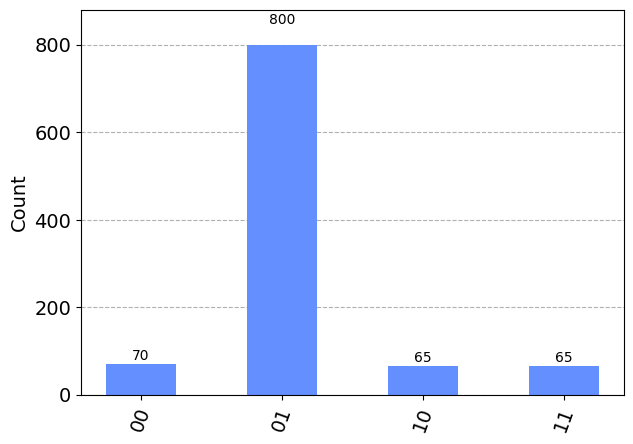

In [352]:
def add_prepare(circuit):
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)

def add_amplify(circuit):
    prepare(circuit)
    circuit.x(0)
    circuit.x(1)
    circuit.x(2)
    circuit.ccz(0, 1, 2)
    circuit.x(0)
    circuit.x(1)
    circuit.x(2)
    prepare(circuit)
    
def add_flipping_verify(circuit):
    circuit.h(2)
    add_verify(circuit)
    circuit.h(2)
    
q = QuantumRegister(3) # We want 3 qubits
c = ClassicalRegister(2) # but want to measure only 2 of them, so we need 2 bits
circuit = QuantumCircuit(q, c) # Sets up the quantum computer, a.k.a. quantum circuit

add_prepare(circuit)
add_flipping_verify(circuit)
add_amplify(circuit)

circuit.measure(q[0:2], c)          # Measure the two qubits 0 and 1, and get some bits
result = execute(circuit, backend, shots=1000).result()    # Run this all 1,000 times
plot_histogram(result.get_counts(circuit))                 # Show a histogram of the results

### Grover's algorithm
Let's put these new operations to work.

In [327]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector
import numpy as np
backend = BasicAer.get_backend('qasm_simulator')

def add_cry(c, theta, x, y):
    c.ry(theta/2, y)
    c.cx(x, y)
    c.ry(-theta/2, y)
    c.cx(x, y)

def add_ccx(c, x, y, z):
    add_cry(c, np.pi/2, y, z)
    c.cx(x, y)
    add_cry(c, -np.pi/2, y, z)
    c.cx(x, y)
    add_cry(c, np.pi/2, x, z)

def add_ccz(c, x, y, z):
    c.h(z)
    add_ccx(c, x, y, z)
    c.h(z)

q = QuantumRegister(3) # We want 3 qubits
c = ClassicalRegister(2) # and also 2 bits
circuit = QuantumCircuit(q, c) # Sets up the quantum computer, a.k.a. quantum circuit

circuit.h(0)
circuit.h(1)
#circuit.x(2) # Need to include this if use X rather than RY operations
circuit.h(2)

# Black box that does X on qubit 2 iff qubits 0 and 1 are in the secret state (and leaves/returns them in that state).
# Secret state is |01>, i.e. qubit 0 = |1>, qubit 1 = |0>.
circuit.ry(np.pi, 1)
add_ccx(circuit, 0, 1, 2)
circuit.ry(-np.pi, 1)
#This one works - equivalent to flipping the sign on the |001> row if everything is in equal superposition.
#Also, only swaps to a state in the second half of the state vector if start in |001> row
#circuit.x(1)
#circuit.ccx(0,1,2)
#circuit.x(1)
v4 = Statevector(circuit)

circuit.h(0)
circuit.h(1)
circuit.h(2)

# Flip the sign on the |000> row:
# Next three lines are equivalent to reversing the state vector
circuit.ry(np.pi,0)
circuit.ry(np.pi,1)
circuit.ry(np.pi,2)
#add_ccz(circuit, 0, 1, 2)
circuit.ccz(2, 1, 0)
# Then we "un-reverse" the state vector
circuit.ry(-np.pi,0)
circuit.ry(-np.pi,1)
circuit.ry(-np.pi,2)

circuit.h(0)
circuit.h(1)
circuit.h(2)

array_to_latex(np.vstack(v4.data))

#circuit.measure(q[0:2], c)          # Measure the two qubits 0 and 1, and get some bits
#result = execute(circuit, backend, shots=1000).result()    # Run this all 1,000 times
#plot_histogram(result.get_counts(circuit))                 # Show a histogram of the results

<IPython.core.display.Latex object>

In [281]:
q = QuantumRegister(3) # We want 3 qubits
c = ClassicalRegister(3) # and also 3 bits
circuit = QuantumCircuit(q, c) # Sets up the quantum computer, a.k.a. quantum circuit

circuit.h(0)
circuit.h(1)
circuit.x(2)
circuit.h(2)
verifier(circuit)

circuit.h(0)
circuit.h(1)
circuit.h(2)

#circuit.ry(np.pi,0)
#circuit.ry(np.pi,1)
#circuit.ry(np.pi,2)
circuit.x(0)
circuit.x(1)
circuit.x(2)
#add_ccz(circuit, 0, 1, 2)
circuit.ccz(2, 1, 0)
# Then we "un-reverse" the state vector
#circuit.ry(-np.pi,0)
#circuit.ry(-np.pi,1)
#circuit.ry(-np.pi,2)
circuit.x(0)
circuit.x(1)
circuit.x(2)

v4 = Statevector(circuit)
array_to_latex(np.vstack(v4.data))

<IPython.core.display.Latex object>